# Intro

Mixup is a very powerful data augmentation tool that is super helpful tool to have in your toolbox, especially when you don't have enough data and are over-fitting.  In this post we are going to dive into what mixup is.  

The goal of this post is to communicate an intuitive understanding of what mixup is and why it works.  The goal of this post is not to show you the intricacies of training a model using mixup - that will be reserved for a future post.  If you don't know what the tool is, it's impossible to have good intuition on how and when to use it.

We will be using the Pets dataset to demonstrate this.

:::{.callout-note}

## Bonus Challenge

As you go through each step, think about what other kinds of data you may be able to apply these concepts to.  Could you apply these transformations to NLP Embeddings?  Could you apply these transformations to Tabular Data? 
:::

# Setup

### Get Libraries/Data

In [ ]:
from fastai.data.external import *
from fastai.vision.all import *
from PIL import Image
import matplotlib.pyplot as plt
from pylab import rcParams
from functools import partial,update_wrapper

In [ ]:
seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
path.ls()

(#2) [Path('/Users/isaacflath/.fastai/data/oxford-iiit-pet/images'),Path('/Users/isaacflath/.fastai/data/oxford-iiit-pet/annotations')]

### Helper Functions

In [ ]:
def plot_images(imgs):
    rcParams['figure.figsize'] = 10, 20
    imgs_len = len(imgs)
    for x in range(0,imgs_len):
        plt.subplot(1,imgs_len,x+1)
        plt.imshow(imgs[x])

### Data Setup

DataBlocks and data loaders are convenient tools that fastai has to help us manage an load data.  There is a lot going on in the `DataBlock` API and I am going to break it down piece by piece in this post so that we can get to talking about mixup.


#### DataBlock


In [ ]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=224)
    )

#### Dataloader

The `dataloader` is what we will actually interact with.  In the `DataBlock` we defined lots of things we need to do to get and transform images, but not where to get them from.  We define that in the `dataloader`.

In [ ]:
dls = pets.dataloaders(path/"images")

# Mixup Explained

To understand what mixup is we need to look at a couple images and see how a Neural Network would see them, and then apply mixup and look at the same images after the augmentation is applied.  To say that another way. we want to understand the inputs and the outputs.

### x: No Mixup

Let's use 2 images as an example.  I have plotted them below.

In [ ]:
im1 = tensor(Image.open((path/'images').ls()[8]).resize((500,371))).float()/255; 
im2 = tensor(Image.open((path/'images').ls()[6]).resize((500,371))).float()/255; 

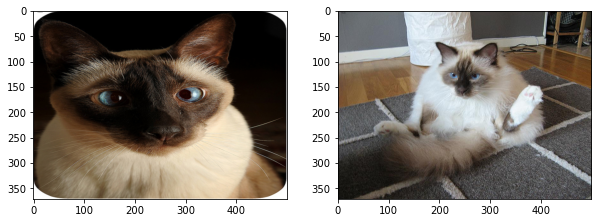

In [ ]:
plot_images([im1,im2])

Great, so the inputs are the pictures.  What are the outputs?  Well the output is going to be what breed they are. Let's see what breed they are.

In [ ]:
(path/'images').ls()[8],(path/'images').ls()[6]

(Path('/Users/isaacflath/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg'),
 Path('/Users/isaacflath/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'))

We can see in the file name that the dog is a leonberger and the cat is a ragdoll.  Now we need to translate that into the one-hot encoded matrix for our model to predict.  Looking at `dls.vocab` gives us all the class names.

In [ ]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

### y: No Mixup

Now we define `y` for these 2 images.  We have 1 column per class. When looking at the vocab above we saw that there were 37 classes.  All of them will be 0 except the target.

Let's start by figuring out which column is the target (ie leonberger and ragdoll).  Then we just need a tensor of length 37 that is all zeros except that position which will be a 1.

In [ ]:
list(dls.vocab).index('leonberger'),list(dls.vocab).index('Ragdoll')

(25, 8)

In [ ]:
# 37 classes long, all 0 except position 25 which represents leonberger and is 1
y_leonberger = tensor([0]*25+[1]+[0]*(37-26))

# 37 classes long, all 0 except position 8 which represents Ragdoll and is 1
y_Ragdoll = tensor([0]*8+[1]+[0]*(37-9))

print(y_leonberger)
print(y_Ragdoll)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Great!  We have our images that go in, and our output we want to predict.  This is what a normal neural network is going to try to predict.  Let's see whats different if we use these 2 images with the Mixup data Augmentation instead.

### x: With Mixup

For the images we are going to apply an augmentation.  `Mixup` mixes to images together.

Let's take a *mix* of the 2 images.  We will take 40% of the first image, and 60% of the second image and plot them.  We are doing this by multiplying the actual pixel values in a weighted average.

For example, if the pixel 1 value from image 1 * .4 + pixel 1 value from image 2 * .6 and that will equal pixel 1 value in my new image.  Take a look at the third image and you can see it really does have a bit of each image in there.

In [ ]:
im_mixup = im1*.6+im2*.4

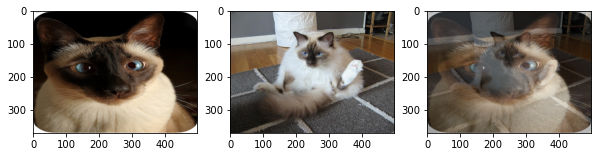

In [ ]:
plot_images([im1,im2,im_mixup])

### y: With Mixup

We have our new augmented image with `mixup`.  Clearly it's not really fair to call it 100% of either class.  In fact it's 60% of one class and 40% of the other.  We should make our `y` represent taht.

We already have our ys when they are 100% of either class, so lets just take 60% of one + 40% of the other exactly like we did for our images.  That will give us an appropriate label.

In [ ]:
# 37 classes long, all 0 except position 25 which represents leonberger and is 1
y_leonberger = tensor([0]*25+[1]+[0]*(37-26))

# 37 classes long, all 0 except position 8 which represents Ragdoll and is 1
y_Ragdoll = tensor([0]*8+[1]+[0]*(37-9))

y_mixup = y_leonberger*.6+y_Ragdoll*.4

print(y_leonberger)
print(y_Ragdoll)
print(y_mixup)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


### What weights?

Here I took 60% of one image and 40% of the other.  You could to a 90/10 split.  Or a 99/1 split.  Or a 50/50 split.  I picked relatively close weights so it's easy to see, but you should play around and see what works.

# FastAI mixup

Applying the basic Mixup in fastai is super easy.  Here's how you can create a CNN using Mixup.

In [ ]:
learn = cnn_learner(dls,resnet34,cbs=MixUp)